<a href="https://colab.research.google.com/github/lakshya897/project/blob/main/plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6508688279999433
GPU (s):
0.1044006240000499
GPU speedup over CPU: 34x


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/plant disease/dataset.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/afb65a40-7512-4d2c-884e-56e6c5010511___RS_Late.B 5380.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/aff90d5c-a3f2-445a-b125-717a00b21fb8___RS_Late.B 6624.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/b07f5c6e-2e85-4b45-a166-522cc484619c___RS_Late.B 6276.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/b09b2807-58ca-4708-904e-05de3032ef92___RS_Late.B 6345.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/b0a1ada0-f496-46a3-827e-2d721dabee59___GHLB2 Leaf 9086.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/b0e6fd13-ea0c-4e04-bdd3-70878b71f353___GHLB2 Leaf 106.1.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/b0fbd7bd-f906-489b-96ff-a2683eb76dd3___RS_Late.B 6173.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Late_blight/b15c92e9-6973-415c-80fe-82703f

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
Image_size=227
Batch_size=32
epochs=50

In [ ]:
path='/content/dataset/PlantVillage/PlantVillage'

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 20638 files belonging to 15 classes.


In [ ]:
class_name=dataset.class_names
class_name

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
len(dataset)

645

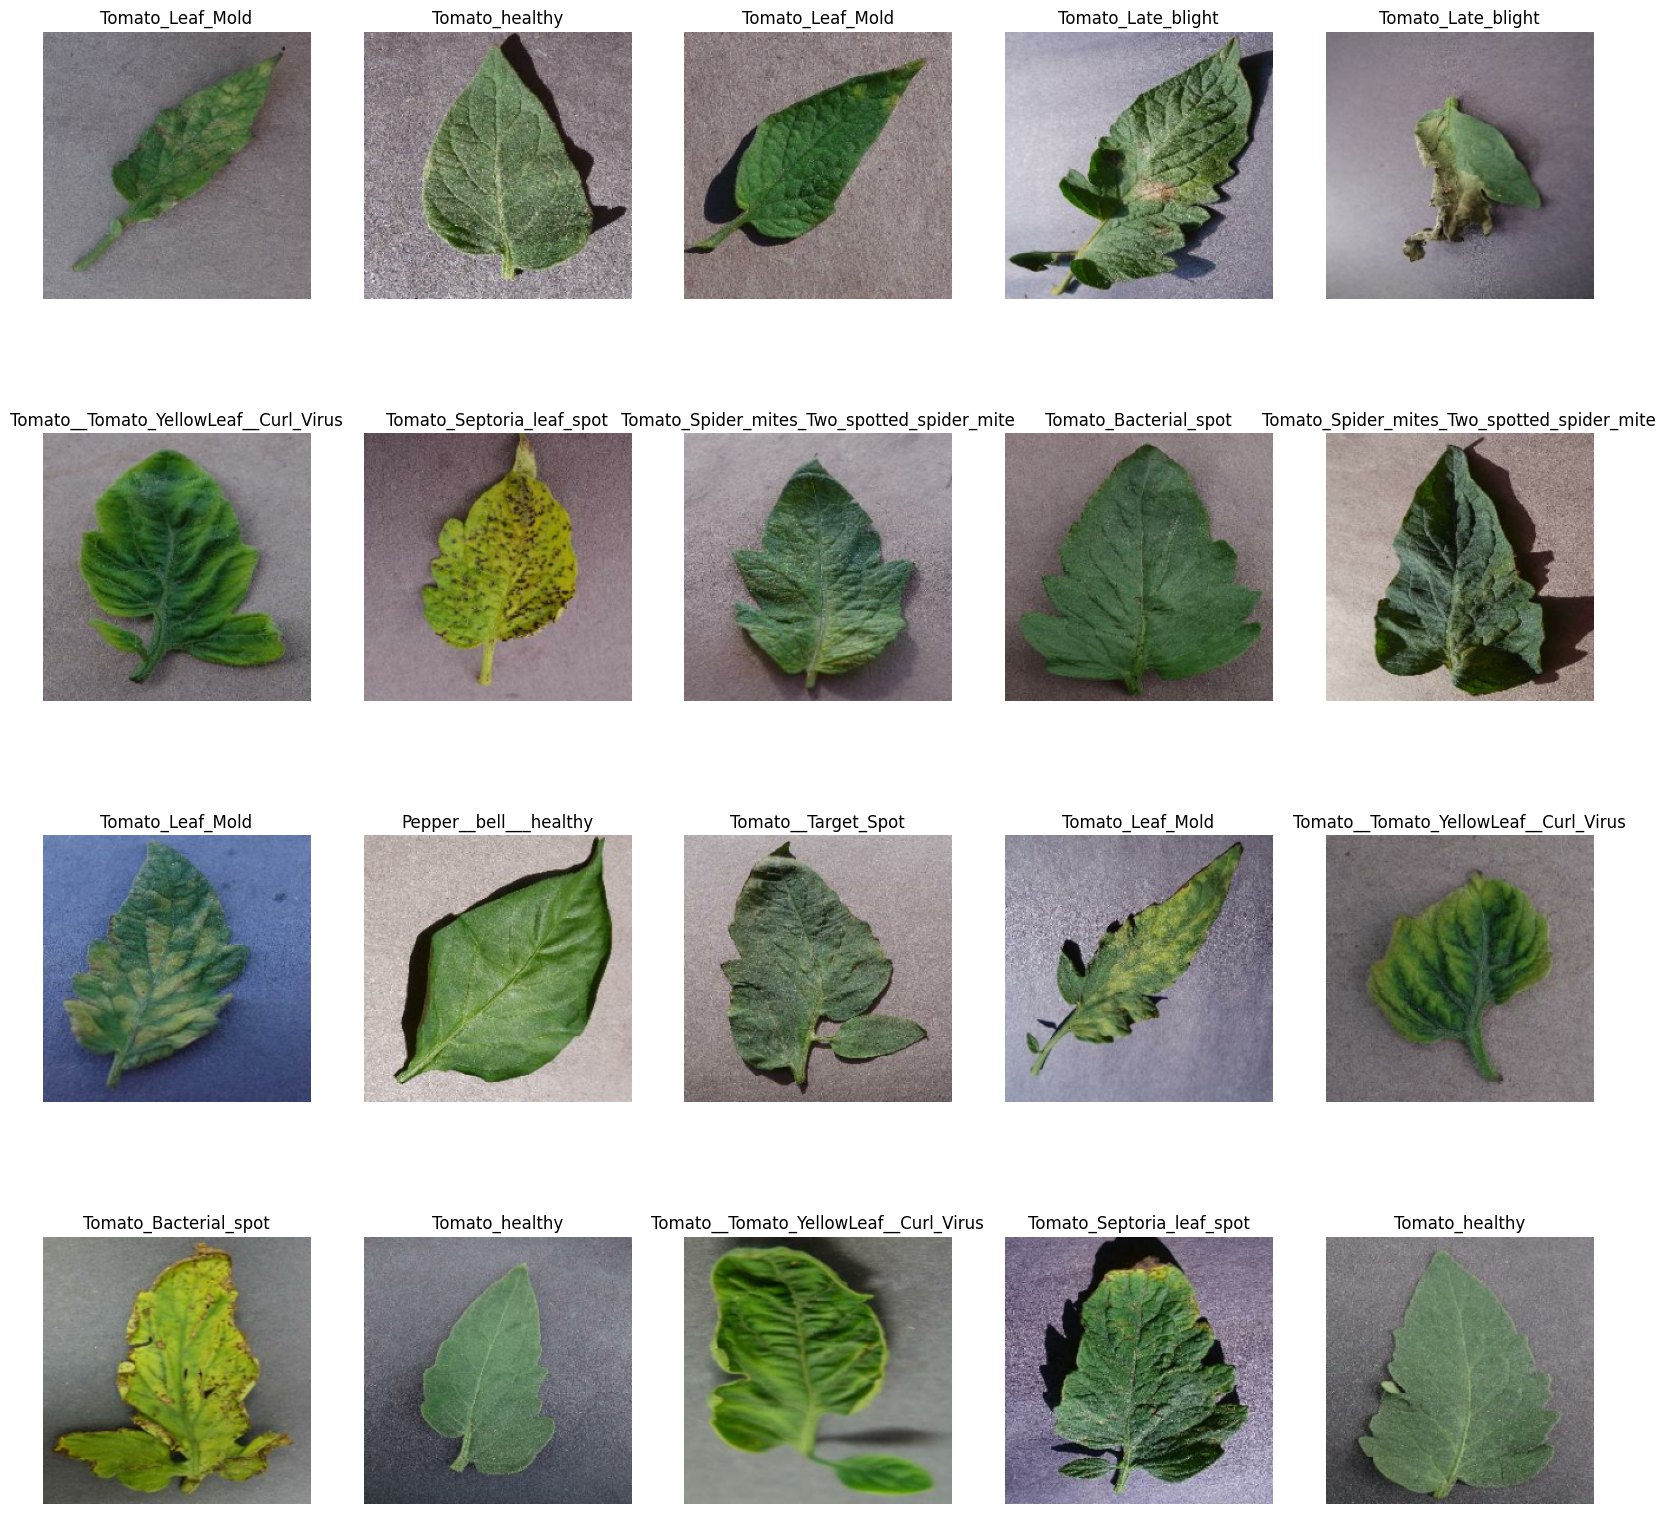

In [ ]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
  for i in range(20):
    ax=plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)


Found 20638 files belonging to 15 classes.
Using 16511 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [ ]:
#train_ds=train_ds.cache().shuffle(6000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds=val_ds.cache().shuffle(6000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Rescaling

In [ ]:
input_shape1 = (1,227,227,3)

model = Sequential([
    resize_and_rescale,
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', input_shape=input_shape1),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    BatchNormalization(),
    Flatten(),
    Dense(4096),
    Activation('relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(4096),
    Activation('relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1000),
    Activation('relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(17),
    Activation('softmax')
])
model.build(input_shape=input_shape1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 227, 227, 3)          0         
                                                                 
 conv2d_22 (Conv2D)          (1, 55, 55, 96)           34944     
                                                                 
 activation (Activation)     (1, 55, 55, 96)           0         
                                                                 
 max_pooling2d (MaxPooling2  (1, 27, 27, 96)           0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (1, 27, 27, 96)           384       
 Normalization)                                                  
                                                                 
 conv2d_23 (Conv2D)          (1, 17, 17, 256)         

In [ ]:
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
earlystop_callback=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=5)

In [ ]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[earlystop_callback],
    batch_size=Batch_size
)

Epoch 1/100
516/516 [==============================] - 65s 103ms/step - loss: 1.6987 - accuracy: 0.5049 - val_loss: 3.0038 - val_accuracy: 0.3879
Epoch 2/100
516/516 [==============================] - 40s 76ms/step - loss: 0.9665 - accuracy: 0.6895 - val_loss: 1.2756 - val_accuracy: 0.6278
Epoch 3/100
516/516 [==============================] - 39s 75ms/step - loss: 0.7099 - accuracy: 0.7683 - val_loss: 1.3958 - val_accuracy: 0.6266
Epoch 4/100
516/516 [==============================] - 42s 81ms/step - loss: 0.5881 - accuracy: 0.8059 - val_loss: 1.2861 - val_accuracy: 0.6574
Epoch 5/100
516/516 [==============================] - 44s 84ms/step - loss: 0.4953 - accuracy: 0.8402 - val_loss: 0.8561 - val_accuracy: 0.7502
Epoch 6/100
516/516 [==============================] - 31s 59ms/step - loss: 0.4351 - accuracy: 0.8611 - val_loss: 0.9238 - val_accuracy: 0.7558
Epoch 7/100
516/516 [==============================] - 31s 59ms/step - loss: 0.3820 - accuracy: 0.8760 - val_loss: 1.5606 - val_a

In [ ]:
score=model.evaluate(val_ds)

129/129 [==============================] - 7s 50ms/step - loss: 0.4276 - accuracy: 0.8914


In [ ]:
score

[0.4275986850261688, 0.891446590423584]

In [ ]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

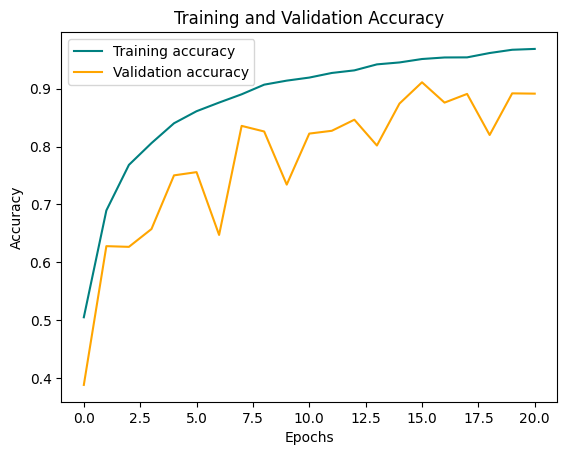

In [ ]:
plt.plot(acc, color='teal', label='Training accuracy')
plt.plot(val_acc,color='orange', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

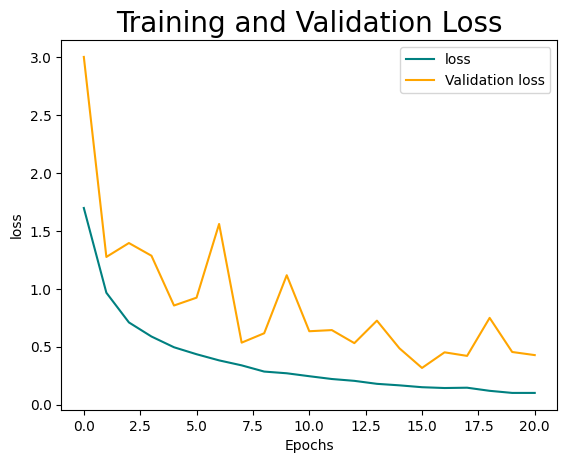

In [ ]:
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss,color='orange', label='Validation loss')
plt.title('Training and Validation Loss',fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model.predict(img_array)

  predicted_class=class_name[np.argmax(predictions[0])]
  confidence =round(100*(np.max(predictions[0])),2)
  return predicted_class ,confidence

1/1 [==============================] - 0s 20ms/step


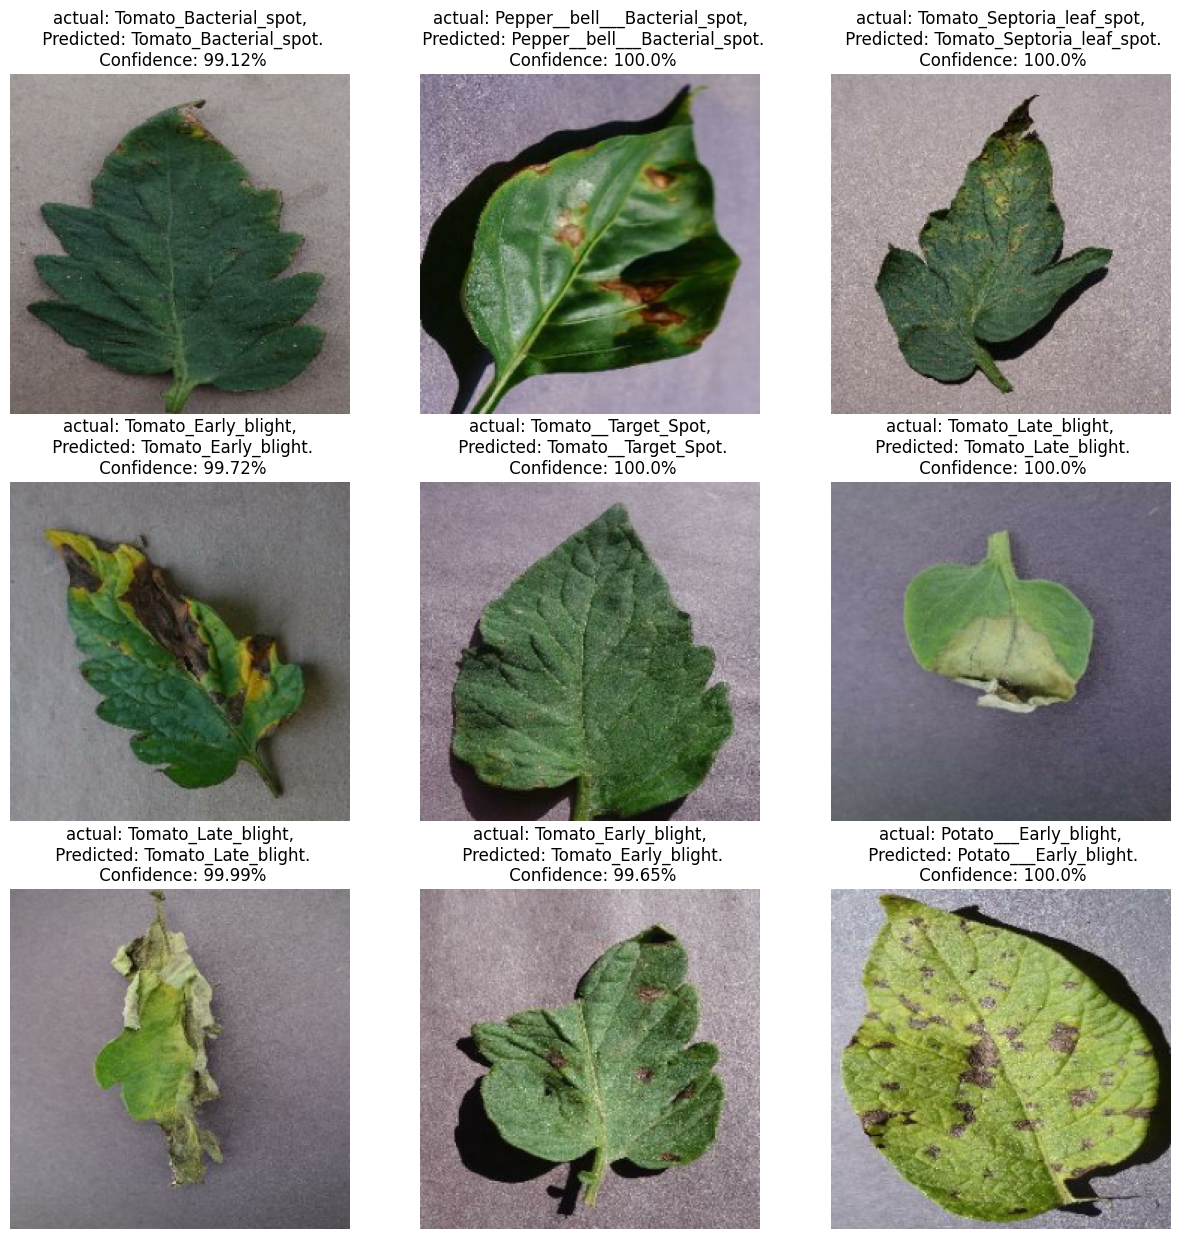

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in val_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence=predict(model,images[i].numpy)
    actual_class=class_name[labels[i]]

    plt.title(f"actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

In [ ]:
model_version=1
model.save(f"/content/drive/MyDrive/plant disease/model/{model_version}")